# Analytical calculations of the bias of the Lyman-alpha forest

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

### First, show that the formulae reproduce the bias value from https://arxiv.org/pdf/1205.2018.pdf appendix 1.

In [154]:
#Calculate tau and flux.

#delta range
y = np.linspace(-10.,10.,10**3+1)

#pdf
p = (1/np.sqrt(2*np.pi))*np.exp(-0.5*y*y)

#tau
a = 0.077
g = 2.16
tau = a*np.exp(g*y)

#flux
F = np.exp(-tau)
mean_F = np.trapz(F*p,y)

In [155]:
#Value found in paper.
print('Reference value:\n0.0925\n')

#Replicate equation A.6 (there is a - sign missing from the paper?)
#d(tau)/dy = gamma * tau(y)
bias_ratio2 = -(1/(mean_F**2))*(np.trapz(p*F*y,y))*(np.trapz(p*F*g*tau,y))
print('Eqn A.6:\n{:2.4f}\n'.format(bias_ratio2))

#The left hand integral from A.6 can be simplified using integration by parts:
#integral of y*p(y)*F(y) = integral of (dF(y)/dy)*p(y)
#This is now identical to the right hand integral.
#Check this gives the same results:
bias_ratio2 = (1/(mean_F**2))*((np.trapz(p*F*g*tau,y)))**2
print('Simplify left integral:\n{:2.4f}\n'.format(bias_ratio2))

#Due to the form of the lognormal transformation, we can complete the square with the gaussian pdf:
#p(y)*tau(y) = a*exp(0.5*gamma^2)*p(y-gamma)
#Calculate p_shift - the shifted pdf p(y-gamma) - and show this is still the same:
p_shift = (1/np.sqrt(2*np.pi))*np.exp(-0.5*(y-g)**2)
bias_ratio2 = (1/(mean_F**2))*(g*a*(np.exp(0.5*(g**2))*(np.trapz(p_shift*F,y))))**2
print('Complete the square with tau:\n{:2.4f}'.format(bias_ratio2))

Reference value:
0.0925

Eqn A.6:
0.0928

Simplify left integral:
0.0928

Complete the square with tau:
0.0928


### The formulae appear to work - define functions to evaluate the integrals

In [135]:
#In my definition (from CoLoRe), tau = a*np.exp(b*D*sG*delta - b*D^2*sG^2)
#The sG in multiplying the delta is different to CoLoRe: 
#here, delta is of variance 1 whereas the delta from CoLoRe has variance greater than 1

In [136]:
def get_tau(delta_G,a,b,sG,D,method=None):
    dG_ones = np.ones_like(delta_G)
    if method == 'FR12':
        tau = a*np.exp(delta_G*b*sG*D)
    else:
        tau = a*np.exp(delta_G*b*sG*D - 0.5*dG_ones*b*(D**2)*(sG**2))
    return tau

In [137]:
#Function to integrate F(y)*p(y) for input parameters a,b,sG and growth factor
#'shift' changes to F(y)*p(y-b*sG*D).
def F_integral(z,a,b,sG,D,shift=False,N_pow=3,tau_method=None):
    #Define the shift size
    centre = shift*(b*sG*D)
    #Define y, shift it if necessary
    y_initial = np.linspace(-10.,+10.,10**N_pow+1)
    y = np.add.outer(y_initial,centre)
    #Helpful variables
    y_ones = np.ones_like(y)
    #Define F, p and integrate
    tau = get_tau(y,a,b,sG,D,method=tau_method)
    F = np.exp(-tau)
    p = (1/np.sqrt(2*np.pi))*np.exp(-0.5*(y-centre)**2)
    integral = np.trapz(F*p,y,axis=0)
    return integral

In [138]:
#Function to integrate F(y)*p(y)*tau(y) for input parameters a,b,sG and growth factor
def F_tau_integral(z,a,b,sG,D,N_pow=3,tau_method=None):
    #Define y
    y_initial = np.linspace(-10.,+10.,10**N_pow+1)
    y = np.add.outer(y_initial,np.zeros(1))
    #Helpful variables
    y_ones = np.ones_like(y)
    #Define F, p and integrate
    tau = get_tau(y,a,b,sG,D,method=tau_method)
    F = np.exp(-tau)
    p = (1/np.sqrt(2*np.pi))*np.exp(-0.5*y**2)
    integral = np.trapz(F*p*tau,y,axis=0)
    return integral

In [139]:
#Function to integrate calculate the theoretical bias.
def theoretical_bias2(z,a,b,sG,D,q='flux',tau_method=None):
    if q=='gaussian':
        return np.ones(z.shape)
    if q=='density':
        return (D**2)
    if q=='tau':
        return (D**2)*(b**2)
    if q=='flux':
        return ((a*b*D)*np.exp(0.5*b*(D**2)*(sG**2)*(b-1)) * (F_integral(z,a,b,sG,D,shift=True,tau_method=tau_method))/(F_integral(z,a,b,sG,D,shift=False,tau_method=tau_method)))**2
    if q=='flux2':
        return (b*D*F_tau_integral(z,a,b,sG,D,tau_method=tau_method)/F_integral(z,a,b,sG,D,tau_method=tau_method))**2

In [140]:
#Show that the correct values from https://arxiv.org/pdf/1205.2018.pdf are still produced 
#(correcting for different definition of lognormal transformation)
z = 2.4
a = 0.077
#Set b*sG*d to match gamma=2.16
b = 2.16
sG = 1.0
d = 1.0
correction = np.exp(0.5*b*(d**2)*(sG**2))

#Value found in paper.
print('Reference value:\n0.0925\n')

#Method 1:
bias_ratio2 = theoretical_bias2(z,a,b,sG,d,q='flux',tau_method='FR12')*(correction)**2
print('Method 1:\n{:2.4f}\n'.format(bias_ratio2))

#Method 2:
bias_ratio2 = theoretical_bias2(z,a,b,sG,d,q='flux2',tau_method='FR12')
print('Method 2:\n{:2.4f}'.format(bias_ratio2[0]))

Reference value:
0.0925

Method 1:
0.0928

Method 2:
0.0928


### For different sets of tuning data, plot the predicted bias and mean flux

In [166]:
#Data from tuning with beta=1.65 (low)
tuning_blo = fits.open('../input_files/tuning_data_151118.fits')
z_blo = tuning_blo[1].data['z']
a_blo = tuning_blo[1].data['alpha']
b_blo = tuning_blo[1].data['beta']
sG_blo = tuning_blo[1].data['sigma_G']
tuning_blo.close()

#Data from tuning with beta=2.0 (high)
tuning_bhi = fits.open('../input_files/tuning_data_beta2.fits')
z_bhi = tuning_bhi[1].data['z']
a_bhi = tuning_bhi[1].data['alpha']
b_bhi = tuning_bhi[1].data['beta']
sG_bhi = tuning_bhi[1].data['sigma_G']
tuning_bhi.close()

#Fitting using a propto ((1+z)/(1+z0))^4.5, sigma_G fixed
a_test = 2.4970568526566983*((1+z_blo)/(1+3.0))**4.5
b_test = np.ones_like(a_test)*1.65
sG_test = 6.861848417826833*((1+z_blo)/(1+3.0))**0.37109491733433425
#a_test = 1.1197990142866043*((1+z_blo)/(1+3.0))**4.5
#b_test = np.ones_like(a_test)*2.0
#sG_test = np.ones_like(a_test)*5.438035741056513

#Get D from the master file
m = fits.open('../example_data/lya_skewers/master.fits')
z = m[3].data['Z']
D = m[3].data['D']
m.close()

#Trim everything as the tuning z starts at lower z and ends at higher z than the master's
a_blo = np.interp(z,z_blo,a_blo)
b_blo = np.interp(z,z_blo,b_blo)
sG_blo = np.interp(z,z_blo,sG_blo)
a_bhi = np.interp(z,z_bhi,a_bhi)
b_bhi = np.interp(z,z_bhi,b_bhi)
sG_bhi = np.interp(z,z_bhi,sG_bhi)
a_test = np.interp(z,z_blo,a_test)
b_test = np.interp(z,z_blo,b_test)
sG_test = np.interp(z,z_blo,sG_test)

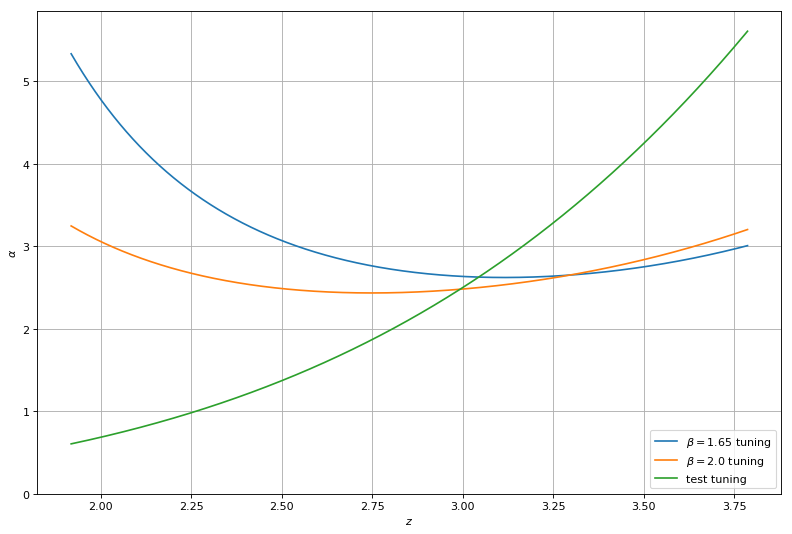

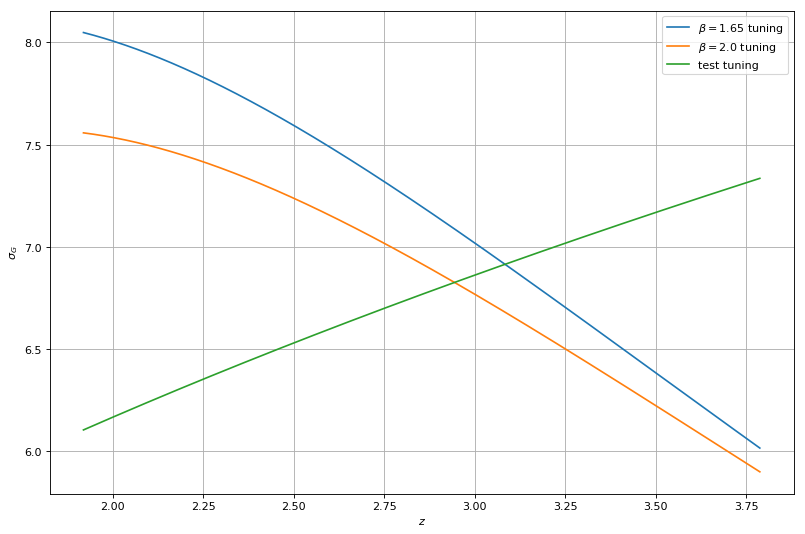

In [167]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,a_blo,label=r'$\beta=1.65$ tuning')
plt.plot(z,a_bhi,label=r'$\beta=2.0$ tuning')
plt.plot(z,a_test,label=r'test tuning')
plt.xlabel(r'$z$')
plt.ylabel(r'$\alpha$')
plt.ylim(ymin=0.0)
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,sG_blo,label=r'$\beta=1.65$ tuning')
plt.plot(z,sG_bhi,label=r'$\beta=2.0$ tuning')
plt.plot(z,sG_test,label=r'test tuning')
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma_G$')
plt.grid()
plt.legend()
plt.show()

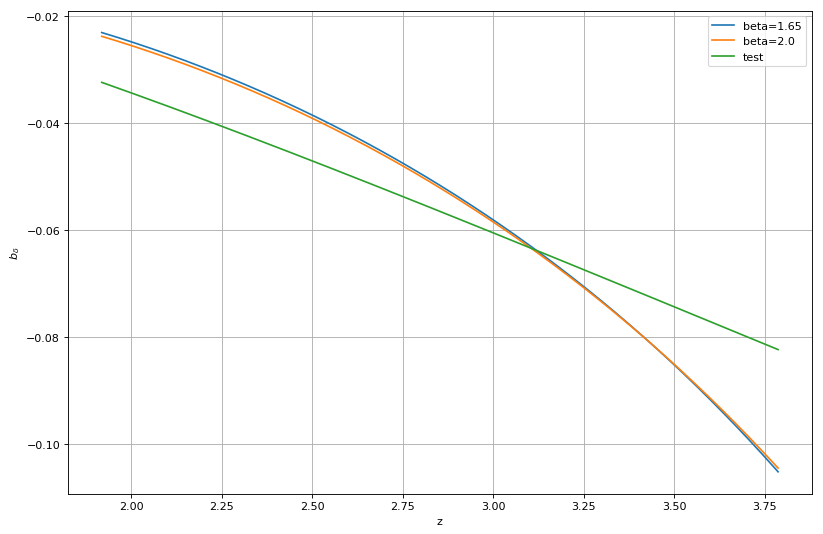

In [168]:
#Plot bias of flux for the different tuning processes
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,-np.sqrt(theoretical_bias2(z,a_blo,b_blo,sG_blo,D,q='flux2')),label='beta=1.65')
plt.plot(z,-np.sqrt(theoretical_bias2(z,a_bhi,b_bhi,sG_bhi,D,q='flux2')),label='beta=2.0')
plt.plot(z,-np.sqrt(theoretical_bias2(z,a_test,b_test,sG_test,D,q='flux2')),label='test')
plt.xlabel('z')
plt.ylabel(r'$b_{\delta}$')
plt.grid()
plt.legend()
plt.show()

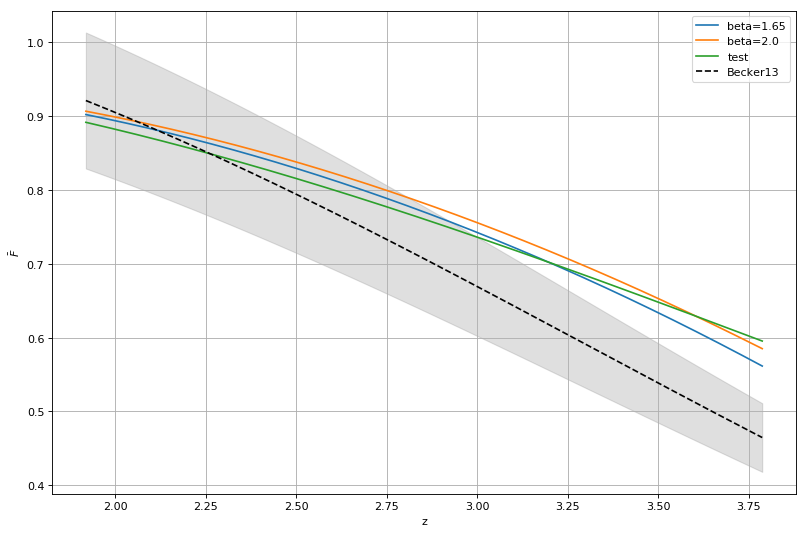

In [169]:
#Plot mean flux for the different tuning processes
from pyacolore import tuning
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,F_integral(z,a_blo,b_blo,sG_blo,D),label='beta=1.65')
plt.plot(z,F_integral(z,a_bhi,b_bhi,sG_bhi,D),label='beta=2.0')
plt.plot(z,F_integral(z,a_test,b_test,sG_test,D),label='test')
plt.plot(z,tuning.get_mean_F_model(z),label='Becker13',linestyle='--',c='k')
plt.fill_between(z,tuning.get_mean_F_model(z)*1.1,tuning.get_mean_F_model(z)*0.9,alpha=0.25,color='gray')
plt.xlabel('z')
plt.ylabel(r'$\bar{F}$')
plt.grid()
plt.legend()
plt.show()

## Explore the variation of bias with the different parameters

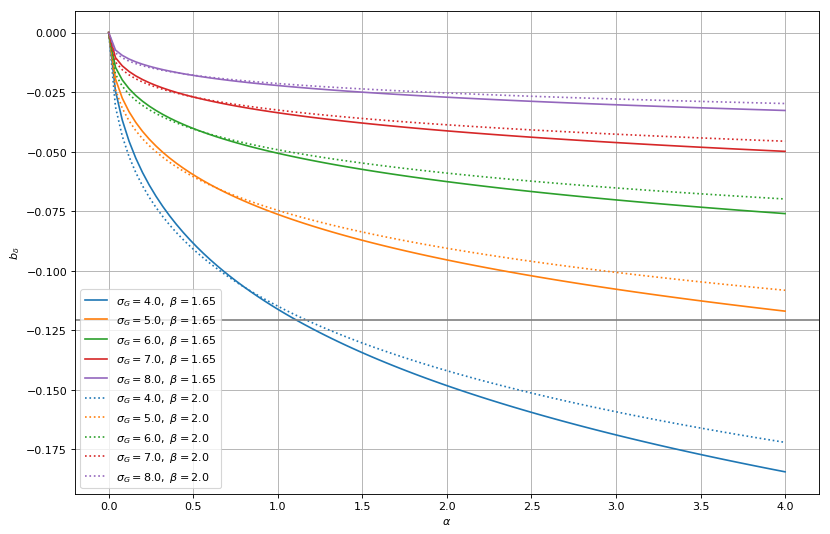

In [74]:
#Plot bias vs a for different b and sG values
z_value = 2.4
a_values = np.linspace(0.0,4.0,101)

b_values = [1.65,2.0]
linestyles = ['-',':']
sG_values = np.linspace(4.0,8.0,5)
colours = ['C0','C1','C2','C3','C4']

d = np.interp(z_value,z,D)
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
for i,b in enumerate(b_values):
    for j,sG in enumerate(sG_values):
        bias = []
        for a in a_values:
            bias += [-np.sqrt(theoretical_bias2(z_value,a,b,sG,d,q='flux2'))]
        plt.plot(a_values,bias,label=r'$\sigma_G={},\ \beta={}$'.format(sG,b),c=colours[j],linestyle=linestyles[i])
plt.axhline(y=-0.1207,color='gray')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$b_{\delta}$')
plt.grid()
plt.legend()
plt.show()

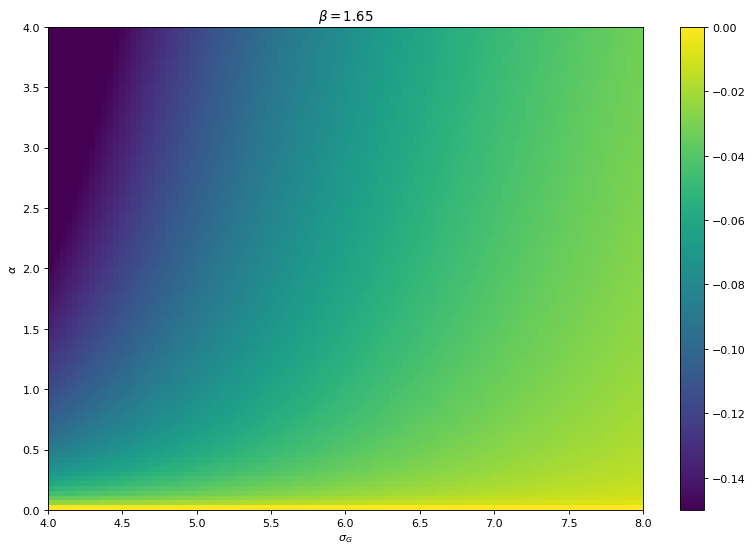

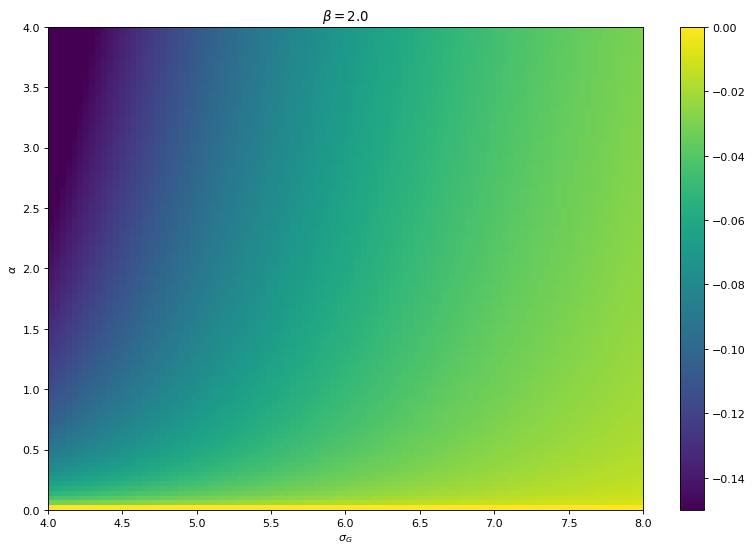

In [41]:
#Plot theoretical bias as a function of alpha and sigma_G in 2D at fixed redshift and b values
z_value = 2.4
a_values = np.linspace(0.0,4.0,101)
b_values= [1.65,2.0]
sG_values = np.linspace(4.0,8.0,101)
bias_grids = {}

d = np.interp(z_value,z,D)
for b in b_values:
    bias_grid = np.zeros((101,101))
    plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
    for i,a in enumerate(a_values):
        for j,sG in enumerate(sG_values):
            bias_grid[i,j] = -np.sqrt(theoretical_bias2(z_value,a,b,sG,d,q='flux2'))
    bias_grids[b] = bias_grid
    plt.imshow(bias_grid,aspect='auto',origin='lower',vmin=-0.15,vmax=0.,extent=[min(sG_values),max(sG_values),min(a_values),max(a_values)])
    plt.xlabel(r'$\sigma_G$')
    plt.ylabel(r'$\alpha$')
    plt.title(r'$\beta={}$'.format(b))
    plt.colorbar()
    plt.show()

/Users/James/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


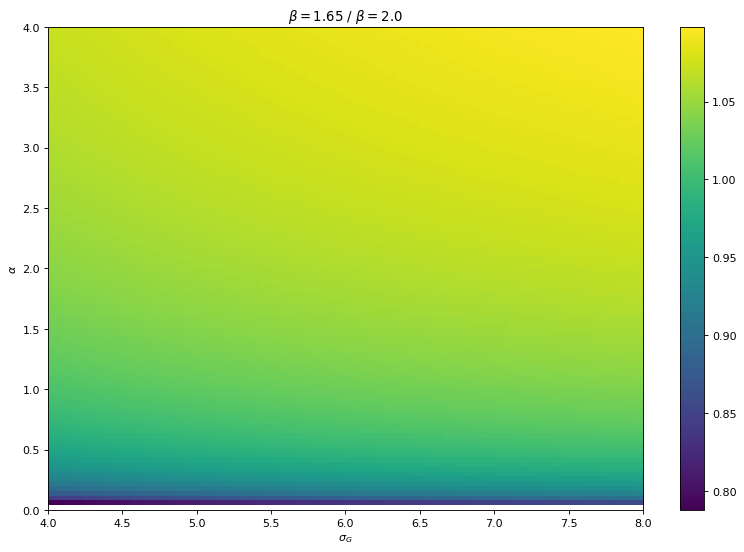

In [15]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(bias_grids[1.65]/bias_grids[2.0],aspect='auto',origin='lower',extent=[min(sG_values),max(sG_values),min(a_values),max(a_values)])
plt.xlabel(r'$\sigma_G$')
plt.ylabel(r'$\alpha$')
plt.title(r'$\beta={}\ /\ \beta={}$'.format(1.65,2.0))
plt.colorbar()
plt.show()